### Laboratorium 5

Interpolacja

```julia
Pkg.add("Interpolations")
```

In [1]:
using Plots

In [2]:
# wylosowanie węzłów interpolacji
xs =  1:1:10
A = [rand() for x in xs]

10-element Array{Float64,1}:
 0.10612916008220119
 0.7026154948158765 
 0.2631253185917317 
 0.8922619665713141 
 0.8271228944374465 
 0.566391967612287  
 0.9776598981724407 
 0.6779967133639757 
 0.8363830685172013 
 0.07898952677560733

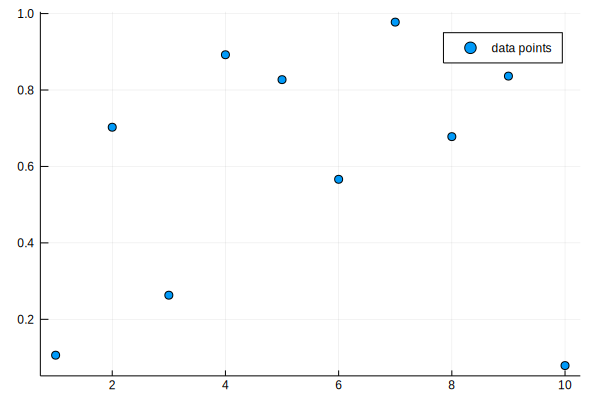

In [3]:
scatter(xs,A, label="data points")

In [4]:
# gęste punkty do rysowania wykresów funkcji interpolujacych
xsf=1:0.01:10

1.0:0.01:10.0

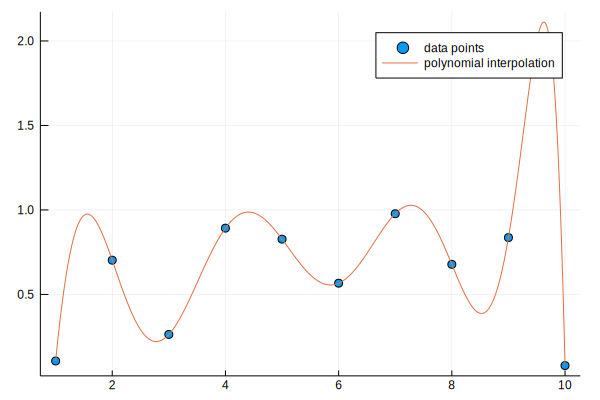

In [5]:
# interpolacja wielomianowa w pakiecie Polynomials
using Polynomials
fit1=polyfit(xs, A)
B=[fit1(x) for x in xsf]
plot!(xsf,B, label="polynomial interpolation")

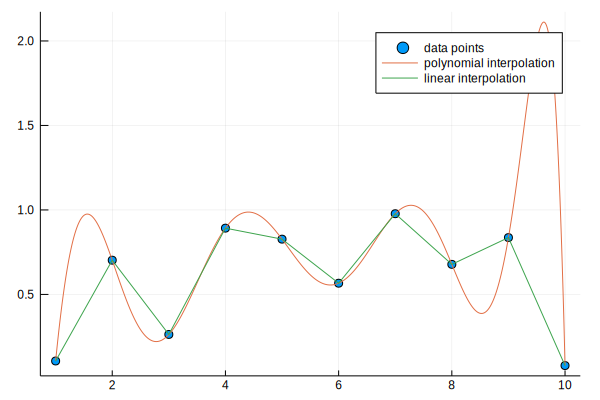

In [6]:
#  interpolacja liniowa z pakietu Interpolations - przykład
using Interpolations
interp_linear = LinearInterpolation(xs, A)
B=[interp_linear(x) for x in xsf]
plot!(xsf,B, label="linear interpolation")

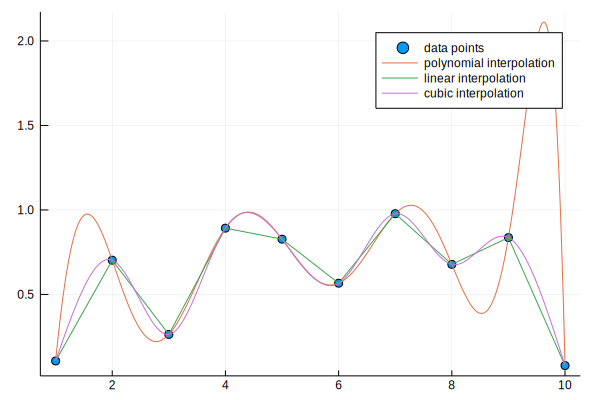

In [7]:
#  interpolacja szescienna 
interp_cubic = CubicSplineInterpolation(xs, A)
B2=[interp_cubic(x) for x in xsf]
plot!(xsf,B2, label="cubic interpolation")

In [8]:
#Interpolacja szescienna to BSpline z warunkami brzegowymi Line i OnGrid. 
#Więcej o konfiguracji warunkow brzegowych w
# dokumentacji https://github.com/JuliaMath/Interpolations.jl/blob/master/doc/Interpolations_algebra.pdf
interp_cubic

10-element extrapolate(scale(interpolate(OffsetArray(::Array{Float64,1}, 0:11), BSpline(Cubic(Line(OnGrid())))), (1:1:10,)), Throw()) with element type Float64:
 0.10612916008220113
 0.7026154948158764 
 0.2631253185917317 
 0.892261966571314  
 0.8271228944374464 
 0.566391967612287  
 0.9776598981724408 
 0.6779967133639757 
 0.8363830685172012 
 0.07898952677560728

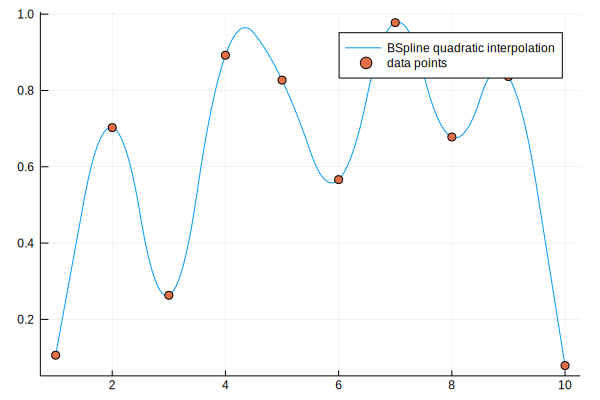

In [9]:
# Przyklad konfiguracji  BSpline-ów
itp = interpolate(A, BSpline(Quadratic(Line(OnCell()))))
B=[itp(x) for x in xsf]
plot(xsf,B, label="BSpline quadratic interpolation")
scatter!(xs,A, label="data points")

In [10]:
using CSV
using Plots
using Polynomials
using Statistics
using LinearAlgebra
using Distributions
using Printf
using OffsetArrays
using Images
using ImageMagick
using Interpolations
using Netpbm #to save pgm file

In [11]:
# abscissa = [1,2,3] x
# ordinate =[1,2,3] y

function lagrange(abscissa_0_indexed,k,x)
    n=length(abscissa_0_indexed)
    numerator =1
    denominator = 1
    for i in 0:1:n-1
        if(i != k)
            numerator *= (x-abscissa_0_indexed[i])
            denominator *=(abscissa_0_indexed[k] - abscissa_0_indexed[i])
        end
    end
    return numerator/denominator
end
        

function lagrange_interpolation(abscissa,ordinate,x)
    if length(abscissa) != length(ordinate) throw("Number of x cordinates differs from number of y cordinates") end
    
    n= length(abscissa)
    abscissa_0_indexed = OffsetArray(abscissa,0:n-1)
    ordinate_0_indexed  = OffsetArray(ordinate,0:n-1)
    
    val = 0
    for k in 0:1:n-1
        val += lagrange(abscissa_0_indexed,k,x) * ordinate_0_indexed[k]
    end
    return val
end







lagrange_interpolation (generic function with 1 method)

In [12]:
# SET PARAMETERS FOR ALL SCATTERS
range_begin =4
range_end =10
num_points = 10
X = map(x->(range_end-range_begin)*x+range_begin,rand(num_points))
Y = rand(num_points)*9 
for i=1:num_points
    @printf "lagrange_interpolation(%f) = %f, f(%f) = %f \n" X[i] lagrange_interpolation(X,Y,X[i]) X[i] Y[i]
end

dense = range_begin:0.01:range_end



lagrange_interpolation(4.762167) = 5.475275, f(4.762167) = 5.475275 
lagrange_interpolation(6.298319) = 2.982899, f(6.298319) = 2.982899 
lagrange_interpolation(7.914883) = 1.120251, f(7.914883) = 1.120251 
lagrange_interpolation(8.960543) = 1.752654, f(8.960543) = 1.752654 
lagrange_interpolation(9.068138) = 4.737768, f(9.068138) = 4.737768 
lagrange_interpolation(6.824264) = 8.694541, f(6.824264) = 8.694541 
lagrange_interpolation(8.253505) = 7.446143, f(8.253505) = 7.446143 
lagrange_interpolation(4.401411) = 3.158698, f(4.401411) = 3.158698 
lagrange_interpolation(9.811198) = 7.901698, f(9.811198) = 7.901698 
lagrange_interpolation(6.395461) = 0.766608, f(6.395461) = 0.766608 


4.0:0.01:10.0

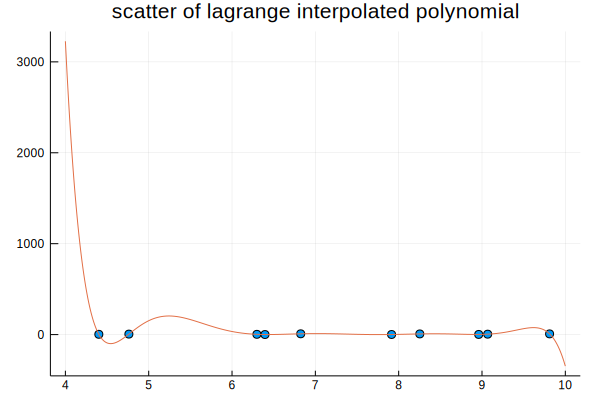

In [13]:
lagrange_scatter = scatter(X,Y,title="scatter of lagrange interpolated polynomial",legend=false)
dense_val = [lagrange_interpolation(X,Y,d) for d in dense]  
plot!(dense,dense_val)


In [14]:

img = load("dd.jpg")

a = []
saved_X = [] # state of (x,y) coordinates are saved. They are used to decide if we have to count new divided differences or we can use previously counted
saved_Y = []

function divided_differences(X,Y)
    global(a)
    if length(X)!=length(Y) throw("Incorrect information about points") end
    # n+1 - number of points 
    n=length(X)-1 # length(x) = n+1
    a=[[] for i in X] # array with n+1 braces

    a[1] = Y 

    for j=2:(n+1)
        for i=1:(n+1 -(j-1))
            push!(a[j],(a[j-1][i+1] - a[j-1][i])/(X[i+j-1]-X[i]))
        end
    end
    return [x[1] for x in a]
end

function newton_interpolation(X,Y,x)
    global(a)
    global saved_X, saved_Y
    if !(saved_X==X && saved_Y ==Y)
        a = divided_differences(X,Y)
        saved_X = X
        saved_Y = Y
    end
        
    val=0
    for i=1:length(a)
        expression = a[i]
        for j=2:i
            expression*=(x-X[j-1])
        end
        val+=expression
    end
    return(val)
end



Error encountered while loading "dd.jpg".
Fatal error:


ErrorException: UnableToOpenBlob `dd.jpg': No such file or directory @ error/blob.c/OpenBlob/2873

In [15]:

for i=1:num_points
    @printf "newton_interpolation(%f) = %f, f(%f) = %f \n" X[i] newton_interpolation(X,Y,X[i]) X[i] Y[i]
end

UndefVarError: UndefVarError: newton_interpolation not defined

In [16]:
newton_scatter =scatter(X,Y,title="scatter of newton interpolated polynomial",legend=false)
dense_val = [newton_interpolation(X,Y,d) for d in dense]  
plot!(dense,dense_val)

UndefVarError: UndefVarError: newton_interpolation not defined

In [17]:
combined_scatter  = scatter(X,Y,label ="interpolated points",title="comparison of interpolation graphs")
newton_val =[newton_interpolation(X,Y,d) for d in dense]
lagrange_val =[lagrange_interpolation(X,Y,d) for d in dense]
fit=polyfit(X, Y)
polynomial_val=[fit(x) for x in dense]
plot!(dense, [newton_val,lagrange_val,polynomial_val],colour=[:red :blue :green], label=["newton" "lagrange" "polynomial"] )



UndefVarError: UndefVarError: newton_interpolation not defined

In [18]:
num_points = [3,7,10,30,40,100,400,1000,1500]
range_begin =4
range_end =10

struct Lagrange
    sd
    mean
end

struct Polynomial
    sd
    mean
end

struct Newton
    sd
    mean
end

lagra =Lagrange([],[])
polynomial = Polynomial([],[])
newton = Newton([],[])


    

for i in num_points
    X = map(x->(range_end-range_begin)*x+range_begin,rand(i))
    Y = rand(i)
    
    ten_measurements = []
    for i in 1:10
        push!(ten_measurements,@elapsed(lagrange_interpolation(X,Y,rand())))
    end
    push!(lagra.sd,std(ten_measurements))
    push!(lagra.mean,mean(ten_measurements))
    
    ten_measurements = []
    for i in 1:10
        push!(ten_measurements,@elapsed(newton_interpolation(X,Y,rand())))
    end
    push!(newton.sd,std(ten_measurements))
    push!(newton.mean,mean(ten_measurements))
    
    
    ten_measurements = []
    polynomial_interpolation = polyfit(X,Y)
    for i in 1:10
        push!(ten_measurements,@elapsed(polynomial_interpolation(rand())))
    end
    push!(polynomial.sd,std(ten_measurements))
    push!(polynomial.mean,mean(ten_measurements))
end

s = scatter(num_points,[lagra.mean, newton.mean, polynomial.mean],yerr=[lagra.sd newton.sd polynomial.sd],colour=[:red :blue :green],label=["lagrange" "newton" "polynomial"],legend=:topleft,title="comparison of speed",xlabel="number of nodes",ylabel="time")


UndefVarError: UndefVarError: newton_interpolation not defined

In [19]:
X = 1:1:10
Y = rand(10)
dense = 1:0.01:10


graph_spline = scatter(X,Y,label="data points")

linear_interpolation = LinearInterpolation(X,Y)
dense_linear = [linear_interpolation(x) for x in dense]
plot!(dense,dense_linear, label="linear spline")

cubic_interpolation = CubicSplineInterpolation(X,Y)
dense_cubic = [cubic_interpolation(x) for x in dense]
plot!(dense,dense_cubic,label="cubic spline")

quadratic_interpolation = interpolate(Y, BSpline(Quadratic(Line(OnCell()))))
dense_quadratic=[quadratic_interpolation(x) for x in dense]
plot!(dense,dense_quadratic, label="BSpline quadratic")

graph_combined = deepcopy(graph_spline)

dense_newton = [newton_interpolation(X,Y,x) for x in dense]
plot!(graph_combined,dense,dense_newton,label="newton/lagrange/poly")
plot!(graph_combined,title = "comparison of interpolation graphs")
plot!(graph_spline,title = "comparison of spline graphs")


plot(graph_spline,graph_combined,layout=(2,1))


UndefVarError: UndefVarError: newton_interpolation not defined


This package has been renamed to StatsPlots.
The name StatPlots has been deprecated.

Please run

`]rm StatPlots`
`]add StatsPlots`

Failure to update will mean that you do not receive new developments.



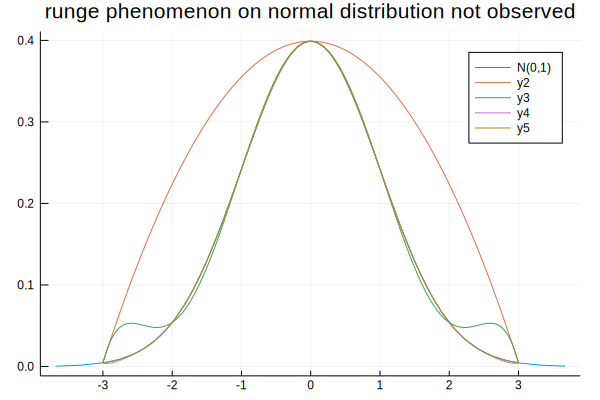

In [20]:
using StatPlots


plot(Normal(0,1),label="N(0,1)",title="runge phenomenon on normal distribution not observed")
X=[-3,0,3]
X1=-3:1:3
X2=-3:0.5:3
X3=-3:0.3:3
function runge(X)
    Y = [pdf(Normal(0,1),x) for x in X]
    fit1 = polyfit(X,Y)
    X_dense = -3:0.01:3
    Y_dense = [fit1(x) for x in X_dense]
    plot!(X_dense,Y_dense)
end

runge(X)
runge(X1)
runge(X2)
runge(X3)

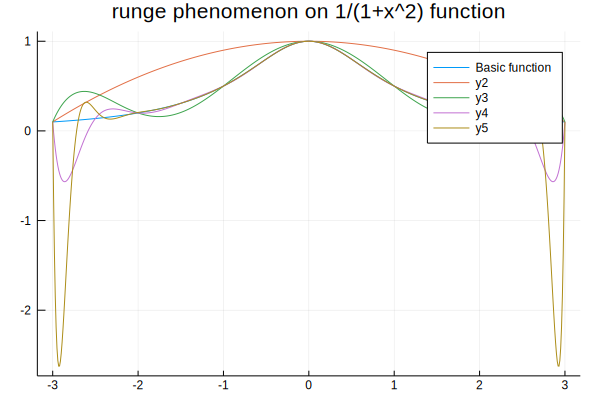

In [21]:
X_dense = -3:0.01:3
Y_dense = [1/(1+x^2) for x in X_dense]
plot(X_dense,Y_dense,label="Basic function",title="runge phenomenon on 1/(1+x^2) function")

X=[-3,0,3]
X1=-3:1:3
X2=-3:0.5:3
X3=-3:0.3:3
function runge(X)
    Y = [1/(1+x^2) for x in X]
    fit1 = polyfit(X,Y)
    X_dense = -3:0.01:3
    Y_dense = [fit1(x) for x in X_dense]
    plot!(X_dense,Y_dense)
end

runge(X)
runge(X1)
runge(X2)
runge(X3)


### Zadania
- Napisać własną implementację interpolacji wielomianowej stosując wprost wzór na <a href="https://www.icsr.agh.edu.pl/~mownit/pdf/03_interpolation_v2.pdf"> wielomian interpolacyjny  Lagrange'a </a>. Język implementacji do wyboru (Julia, C). Przetestować swoją implementację na wylosowanych węzłach interpolacji w wybranym przedziale. Narysować wykres wielomianu interpolacyjnego w tym przedziale wraz z wezlami interpolacji. 

- Zrobic to samo dla metody <a href="https://www.icsr.agh.edu.pl/~mownit/pdf/03_interpolation_v2.pdf"> Newtona (metoda ilorazów róznicowych)</a>. Zadbac o to, żeby ilorazy wyliczać tylko raz dla danego zbioru wezłow interpolacji. Jezyk implementacji wybrac taki sam, jak w poprzednim punkcie. Narysować wykres wielomianu interpolacyjnego dla tych samych danych, co w poprzednim punkcie.

- Zastosowac interpolację wielomianową z pakietu Polynomials (jesli wybralismy Julie) albo z 
funkcji <i> gsl_interp_polynomial</i> z pakietu <a href="https://www.gnu.org/software/gsl/doc/html/interp.html#">GSL</a> (jesli wybraliśmy C) do tych samych danych, co w poprzednich punktach. Porównać wszystkie 3 wyniki interpolacji wielomianowej na jednym wykresie. Co zauważamy? Dlaczego?

- Porownać metody poprzez pomiar czasu wykonania dla zmiennej ilości węzłow interpolacji. Dokonac pomiaru 10 razy i policzyc wartość średnią oraz oszacować bład pomiaru za pomoca odchylenia standardowego.  Narzedzie do analizy danych do wyboru (Julia, R)

- Poeksperymentowac z  interpolacją funkcjami sklejanymi (minimum dwie rozne funkcje sklejane),  narysowac wykresy i porownac z wykresami interpolacji wielomianowej. 

- Zademonstrowac  efekt Rungego. 

- Zbadać i zademonstrować podczas zajęc rózne algorytmy interpolacji stosowane w grafice komputerowej (np. do zmiany wielkości obrazu). Można korzystac z gotowych rozwiazań, ale trzeba wiedzieć, jak te algorytmy dzialaja. Do zaliczenia tego zadania potrzebne jest demonstracja i porownanie działania conajmniej dwóch metod.

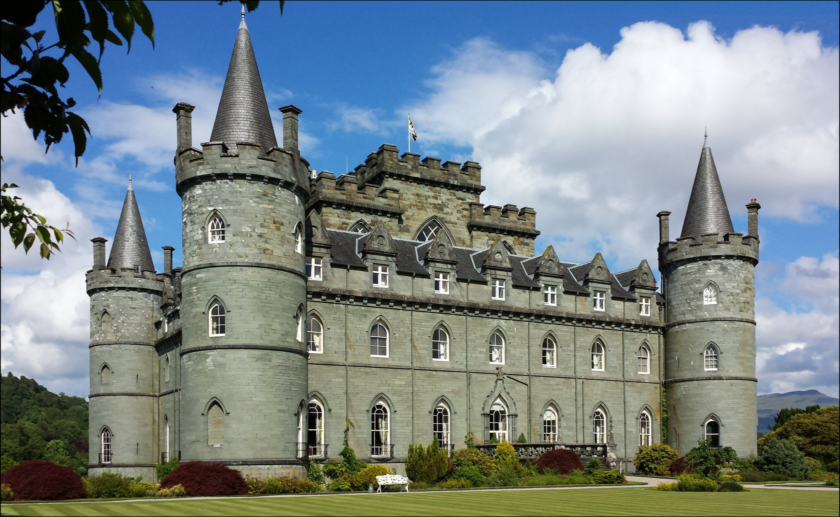

Size of photo before interpolation: (2064, 3354)


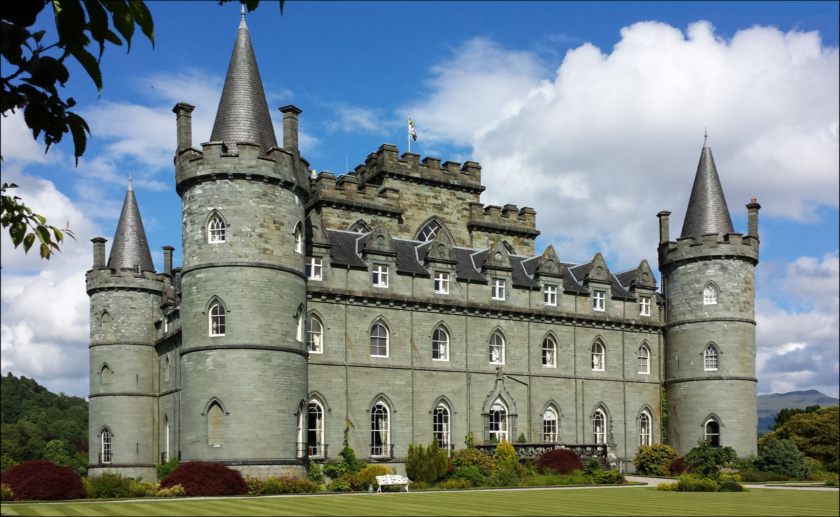

┌ Warning: interpolate(A, BSpline(Linear()), OnGrid()) is deprecated, use interpolate(A, BSpline(Linear()))
│   caller = enlarge(::Array{RGB{Float64},2}, ::Float64) at In[22]:6
└ @ Main ./In[22]:6
┌ Warning: `getindex(itp::AbstractInterpolation{T, N}, i::Vararg{ExpandedIndexTypes, N}) where {T, N}` is deprecated, use `itp(i...)` instead.
│   caller = enlarge(::Array{RGB{Float64},2}, ::Float64) at In[22]:7
└ @ Main ./In[22]:7


Size of photo after interpolation: (8256, 13416)


In [22]:

function enlarge(A::Matrix, factor::AbstractFloat)
    lx, ly = size(A)
    nx, ny = round.(Int, factor .* (lx, ly)) #sizes of new photo
    vx, vy = range(1,stop=lx,length=nx), range(1, stop=ly, length=ny)
    itp = interpolate(A, BSpline(Linear()), OnGrid())
    return itp[vx, vy]
end
 

A = load("castle.jpg") |> Matrix{RGB{Float64}};
println("Size of photo before interpolation: ", size(A))
display(A)
Alarge = enlarge(A, 4.0);
display(Alarge)
println("Size of photo after interpolation: ", size(Alarge))

save("castle1.jpg", Alarge)



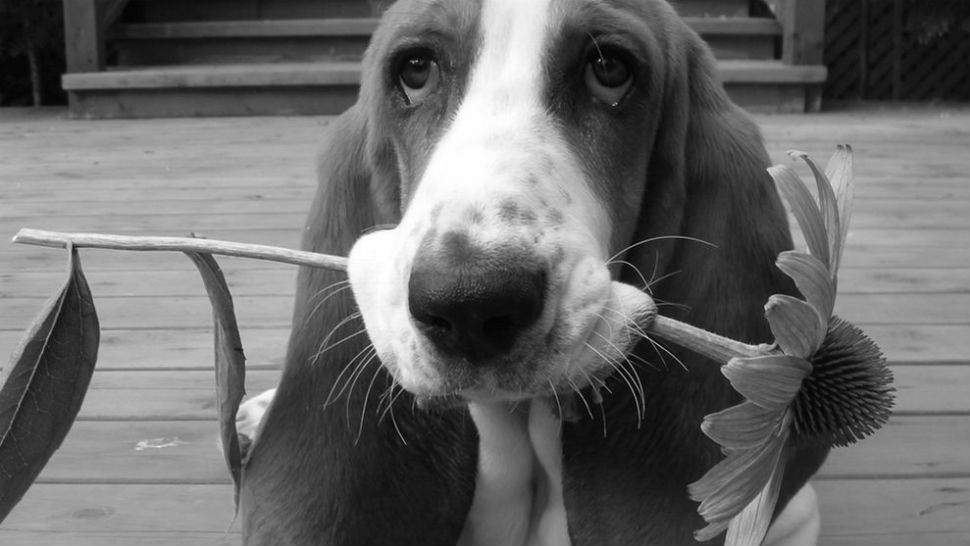

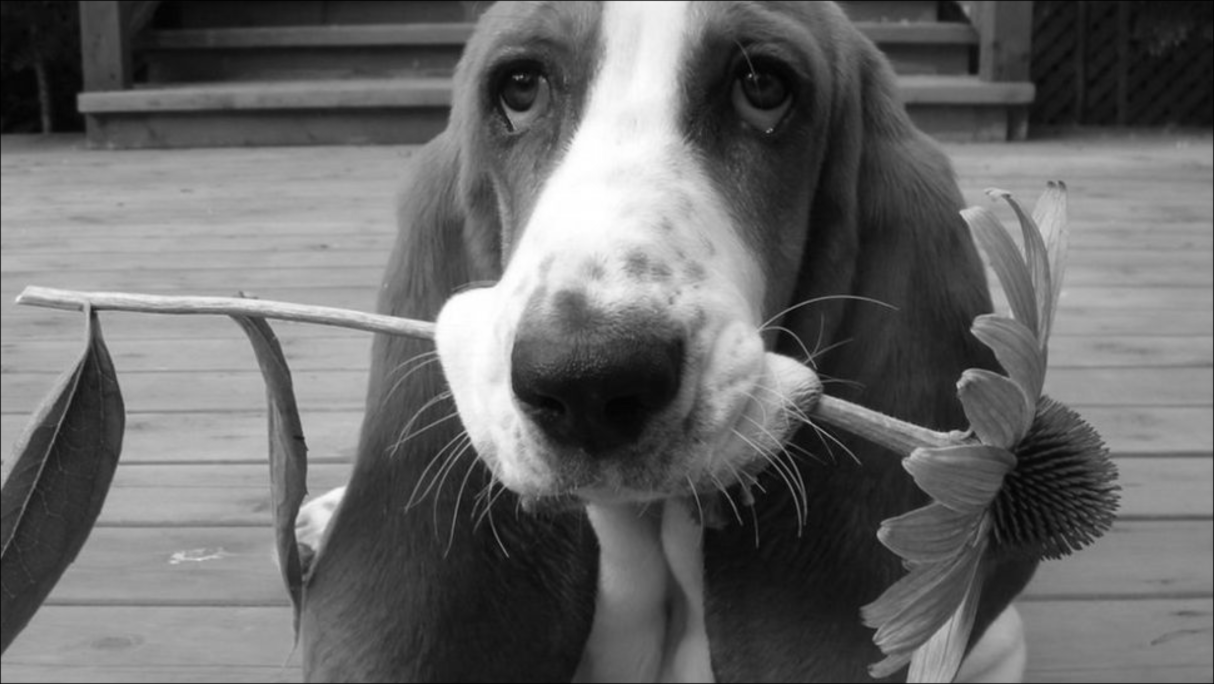

Size of photo before interpolation: (546, 970)
Size of photo after interpolation: (5460, 9700)


In [23]:
I = load("dog.pgm")
display(I)
println("Size of photo before interpolation: ", size(I))
I=convert(Array{Float64},I)
R1 , C1 = size(I) #546 970
R2, C2 = (10*R1,10*C1)
M = zeros(R2,C2)
for r2 = 1:R2
    for c2 = 1:C2
        r1 = round((r2-1)/(R2-1)*(R1-1)+1)
        c1 = round((c2-1)/(C2-1)*(C1-1)+1)
        M[r2,c2] = I[convert(Int64,r1), convert(Int64,c1)]
    end
end


save("dog1.pgm",M)
I = load("dog1.pgm")
display(I)
println("Size of photo after interpolation: ", size(I))
# M = convert(Array{Gray{Normed{UInt8,8}}}M)
# display(M)

In [24]:
struct Photo
    r 
    c 
    v
end

function is_node(M,point)
    r,c = point
    r_index = findfirst(isequal(r),M.r)
    c_index = findfirst(isequal(c),M.c)
    if r_index == nothing || c_index == nothing 
        return false
    else 
        return true
    end
end

function set_val(M,point,val)
    if !is_node(M,point) throw("Trying to set value for not existing point") end
    r,c = point
    r_index = findfirst(isequal(r),M.r)
    c_index = findfirst(isequal(c),M.c)
    M.v[r_index,c_index] = val
end

function get_val(M,point)
    if(!is_node(M,point)) throw("Trying to get value to point that doesnt exist") end
    r,c = point
    r_index = findfirst(isequal(r),M.r)
    c_index = findfirst(isequal(c),M.c)
    return M.v[r_index,c_index]
end

picture = load("dog.pgm")
picture=convert(Array{Float64},picture)
R ,C = size(picture)
A1 = Photo(1:1:R,1:1:C,picture)

scale = 2
A2r = range(1.0,stop=last(A1.r),length=length(A1.r)*scale)
A2c = range(1.0,stop=last(A1.c),length=length(A1.c)*scale)

A2 = Photo(A2r,A2c,zeros(R,C))

c=1
for r2 in A2.r
    if is_node(A1,(r2,c))
        value = get_val(A1,((r2-1)/(length(A2.r)-1)*(length(A1.r-1) +1)))
        set_val(A2,(r2,c),) = value
    else
        a = r2
        b = r2
        while(!is_node(A1,a)) a-=1 end
        while(!is_node(A1,b)) b+=1 end
        value = get_val(A1,(a,c)) + (r2-a)(b-a)(get_val(A1,(b,y))-get_val(A1,(a,c)))
        set_val(A2,(r2,y),value)     
    end
end


# I = load("k.pgm")
# println(size(I))
# # M = convert(Array{Gray{Normed{UInt8,8}}}M)
# # display(M)

MethodError: MethodError: no method matching -(::StepRange{Int64,Int64}, ::Int64)
Closest candidates are:
  -(!Matched::Complex{Bool}, ::Real) at complex.jl:298
  -(!Matched::Missing, ::Number) at missing.jl:97
  -(!Matched::Base.CoreLogging.LogLevel, ::Integer) at logging.jl:107
  ...

In [25]:
a,b = (1,2)
b

2

In [26]:
a = [1 2 ; 3 4 ; 5 6]
display(a)
a[2,:]

3×2 Array{Int64,2}:
 1  2
 3  4
 5  6

2-element Array{Int64,1}:
 3
 4